In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2


In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import Precision, Recall  # ADD THIS LINE

In [3]:
# Load CSVs
df_1and2 = pd.read_csv('burns_1and2.csv')
df_3 = pd.read_csv('burns_3rd.csv')

# Assign labels: 0 = 1st/2nd degree (urgent care), 1 = 3rd degree (ER)
df_1and2['binary_label'] = 0
df_3['binary_label'] = 1

# Combine
df_all = pd.concat([df_1and2, df_3], ignore_index=True)
print(df_all['binary_label'].value_counts())

# Train-validation split
train_df, val_df = train_test_split(
    df_all, test_size=0.2, stratify=df_all['binary_label'], random_state=42
)
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))

binary_label
0    4876
1    1023
Name: count, dtype: int64
Train samples: 4719
Validation samples: 1180


In [4]:
# Compute class weights for imbalanced dataset
y_train = train_df['binary_label'].values
weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train), 
    y=y_train
)
class_weights = dict(enumerate(weights))
print("Class weights:", class_weights)

Class weights: {0: 0.6048449115611382, 1: 2.8844743276283618}


In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Define augmentation transforms
train_transform = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),  # FIXED: Added missing , p=0.5)
    A.GaussianBlur(blur_limit=3, p=0.3),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

class EnhancedBurnDataGenerator(Sequence):
    def __init__(self, df, batch_size=BATCH_SIZE, transform=None, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.transform = transform
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]
        
        images = []
        labels = []
        
        for _, row in batch_df.iterrows():
            # Load image as numpy array
            img = cv2.imread(row['filepath'])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Apply transforms
            if self.transform:
                transformed = self.transform(image=img)
                img = transformed['image']
            else:
                img = img / 255.0
            
            images.append(img)
            labels.append(row['binary_label'])
        
        return np.array(images), np.array(labels)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

C:\Users\dabne\anaconda3\envs\tf-gpu-final\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [6]:
# Create enhanced generators with augmentation
train_gen = EnhancedBurnDataGenerator(
    train_df, 
    batch_size=BATCH_SIZE, 
    transform=train_transform
)

val_gen = EnhancedBurnDataGenerator(
    val_df, 
    batch_size=BATCH_SIZE, 
    transform=val_transform, 
    shuffle=False
)

In [7]:
def create_efficientnet_model():
    # Load pre-trained EfficientNetB0
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    
    # Freeze early layers, fine-tune later ones
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

model = create_efficientnet_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]  # FIXED: Use metric classes instead of strings
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              5

In [8]:
# Define callbacks without ModelCheckpoint to avoid serialization issues
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    class_weight=class_weights,
    callbacks=callbacks_list,
    verbose=1
)

# Save only the model weights to avoid serialization issues
model.save_weights('best_burn_model_weights.h5')
print("Model weights saved successfully!")
print("Note: The current model already contains the best weights due to EarlyStopping with restore_best_weights=True")

Epoch 1/20
148/148 [==============================] - 17s 97ms/step - loss: 0.7333 - accuracy: 0.5830 - precision: 0.2377 - recall: 0.6369 - val_loss: 1.1125 - val_accuracy: 0.1746 - val_precision: 0.1739 - val_recall: 1.0000 - lr: 0.0010
Epoch 2/20
148/148 [==============================] - 14s 94ms/step - loss: 0.6383 - accuracy: 0.6287 - precision: 0.2742 - recall: 0.6932 - val_loss: 0.6197 - val_accuracy: 0.6856 - val_precision: 0.3440 - val_recall: 0.8927 - lr: 0.0010
Epoch 3/20
148/148 [==============================] - 14s 95ms/step - loss: 0.6504 - accuracy: 0.6345 - precision: 0.2752 - recall: 0.6785 - val_loss: 0.9991 - val_accuracy: 0.2195 - val_precision: 0.1821 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/20
148/148 [==============================] - 14s 94ms/step - loss: 0.6163 - accuracy: 0.6425 - precision: 0.2890 - recall: 0.7274 - val_loss: 0.8876 - val_accuracy: 0.3102 - val_precision: 0.2006 - val_recall: 0.9951 - lr: 0.0010
Epoch 5/20
148/148 [========================

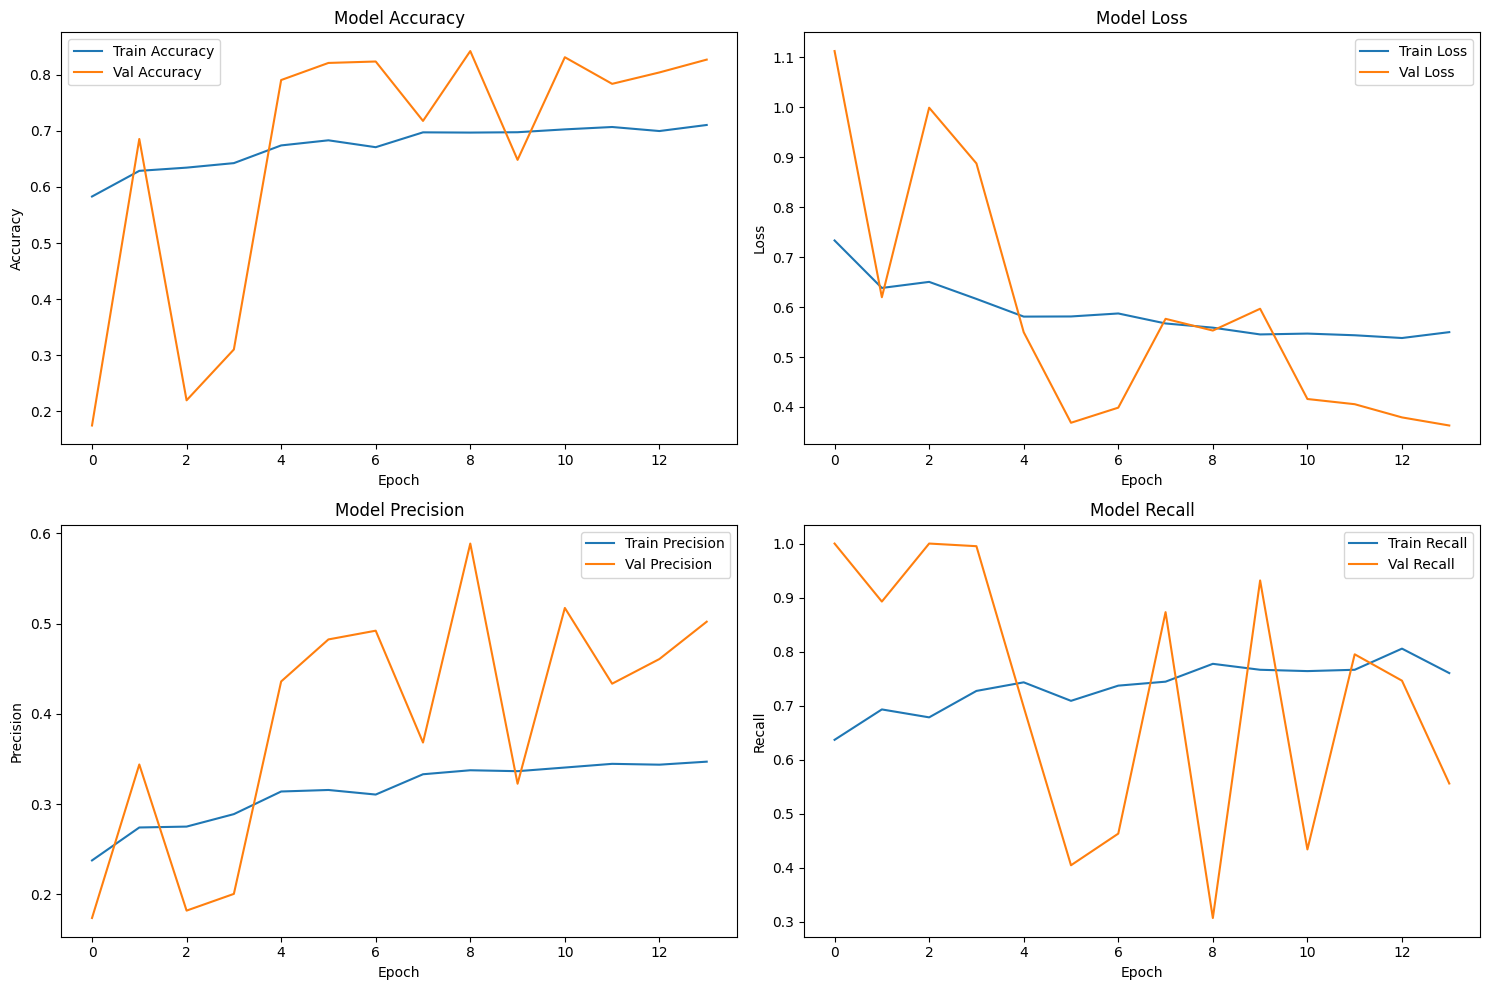

In [9]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss')
axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [10]:
# The current model already has the best weights loaded by EarlyStopping
# Predict on validation set
val_preds = model.predict(val_gen)
val_preds_binary = (val_preds > 0.5).astype(int).flatten()

# Classification report
print("Classification Report:")
print(classification_report(val_df['binary_label'], val_preds_binary))

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(val_df['binary_label'], val_preds_binary)
print(cm)

# Calculate final accuracy
final_accuracy = np.mean(val_df['binary_label'] == val_preds_binary)
print(f"\nFinal Validation Accuracy: {final_accuracy:.4f}")

37/37 [==============================] - 3s 54ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       975
           1       0.59      0.31      0.40       205

    accuracy                           0.84      1180
   macro avg       0.73      0.63      0.66      1180
weighted avg       0.82      0.84      0.82      1180


Confusion Matrix:
[[931  44]
 [142  63]]

Final Validation Accuracy: 0.8424


In [11]:
# Try a lower threshold to boost recall for class 1
for thresh in [0.5, 0.4, 0.3]:
    print(f"\n--- Results at threshold {thresh} ---")
    val_preds_thresh = (val_preds > thresh).astype(int).flatten()
    print(classification_report(val_df['binary_label'], val_preds_thresh))
    print(confusion_matrix(val_df['binary_label'], val_preds_thresh))



--- Results at threshold 0.5 ---
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       975
           1       0.59      0.31      0.40       205

    accuracy                           0.84      1180
   macro avg       0.73      0.63      0.66      1180
weighted avg       0.82      0.84      0.82      1180

[[931  44]
 [142  63]]

--- Results at threshold 0.4 ---
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       975
           1       0.51      0.35      0.42       205

    accuracy                           0.83      1180
   macro avg       0.69      0.64      0.66      1180
weighted avg       0.81      0.83      0.82      1180

[[906  69]
 [133  72]]

--- Results at threshold 0.3 ---
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       975
           1       0.50      0.40      0.45       205

    accuracy                      

In [15]:
# Save model weights only (avoids serialization issues with custom metrics)
model.save_weights('burn_classification_model_final_weights.h5')
print("Model weights saved successfully!")



Model weights saved successfully!
